# Video Viewer (for Calcium Imaging)
![status](https://img.shields.io/badge/status-in%20progress-orange)

<div style="text-align: center;">
    <img src="./assets/230620_video-viewer.png" alt="video viewer preview" width="450"/>
</div>

## Summary

This workflow is intended to demonstrate the visualization of a Calcium Imaging  image stack with HoloViz and Bokeh tools.

For details specific to this workflow, such as goals, specifications, and bottlenecks, please this workflow's [readme](./readme_eeg-viewer.md).

For a summary of Calcium Imaging research, data, and software, please see [neuro/wiki/Calcium-Imaging-notes](https://github.com/holoviz-topics/neuro/wiki/Calcium-Imaging-notes).

## Imports and config

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Requirements</p>
    <p>This workflow notebook requires the <a href="./environment.yml">environment</a> specified in this workflow directory.</p>
</div>


In [1]:
%load_ext autoreload
from neurodatagen.ca_imaging import simulate_miniscope_data
import panel as pn; pn.extension(throttled=True)
import hvplot.xarray
import holoviews as hv; hv.extension('bokeh')
from holoviews.streams import Stream
import param
from functools import partial
import numpy as np

## Generate simulated data

The `simulate_miniscope_data` function generates synthetic calcium imaging data by simulating neural activity through spatial footprints and temporal calcium traces, while incorporating motion artifacts and realistic background noise. 

The function outputs a numpy array of 8-bit unsigned integers, encapsulated within an `xarray.DataArray`. This array represents the generated imaging data with dimensions corresponding to frame height, frame width, and frame number.

In [111]:
ncell = 100
dims = {'height': 512, 'width': 512, 'frame': 300}

data = simulate_miniscope_data(ncell=ncell, dims=dims)
data

<xarray.DataArray 'Simulated Miniscope Data' (frame: 300, height: 512,
                                              width: 512)>
dask.array<getitem, shape=(300, 512, 512), dtype=uint8, chunksize=(300, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 504 505 506 507 508 509 510 511
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">RAM Warning</p>
    <p>In the next steps, `.compute()` converts the underlying dask array representation into an in-memory ndarray. Make sure you have enough available RAM for such operation.</p>
</div>


In [115]:
# Optional: estimate the memory usage
if True:
    item_size = np.dtype(data.dtype).itemsize
    num_elements = np.prod(data.shape)
    ram_needed = num_elements * item_size

    import psutil
    mem = psutil.virtual_memory()

    print(f"Data size: {ram_needed/1e9:.2f} GB")
    print(f"Available RAM: {(mem.available/1e9):.2f} GB")

Data size: 0.08 GB
Available RAM: 13.81 GB


In [117]:
%%time
# if data size < available ram
data = data.compute()

CPU times: user 496 µs, sys: 41 µs, total: 537 µs
Wall time: 586 µs


## Plot Simulated Data

### Version 1: Simple viewer, hvplot with default slider

In [34]:
data.hvplot.image(groupby="frame", cmap="Viridis", frame_height=400, frame_width=400, colorbar=False)

:DynamicMap   [frame]
   :Image   [width,height]   (Simulated Miniscope Data)

### Version 2: Intermediate viewer, hvPlot with Player Widget and slice dim views

In [127]:
fs = 30 # frames per second
frames = data.coords["frame"].values

video_player = pn.widgets.Player(
    length=len(data.coords["frame"]),
    interval=1000//fs, # ms per frame
    value=int(frames.min()),
    max_width=400,
    max_height=90,
    loop_policy="loop",
    sizing_mode="stretch_width",
)

main_h_w = data.hvplot.image(
    groupby="frame",
    cmap="Viridis",
    frame_height=400,
    frame_width=400,
    colorbar=False,
    widgets={"frame": video_player},
    widget_layout=pn.Column,
    widget_location="top",
)

h_t = data.mean(['width']).hvplot.image(x='frame',
    cmap="Viridis",
    frame_height=400,
    frame_width=100,
    colorbar=False,
    xticks=data.frame[[0,-1]].values,
    yticks=data.height[[0,-1]].values,
    ylabel='',
)

def update_vline(value, x=None):
    if x is not None:
        value = int(x)
    return hv.VLine(value)

def update_hline(value):
    return hv.HLine(value)

# Create dynamic vertical line
dmap_vline = hv.DynamicMap(update_vline, streams=[video_player.param.value]).opts(color='red', alpha=.6, line_width=3)

# Create dynamic horizontal line
dmap_hline = hv.DynamicMap(update_hline, streams=[video_player.param.value]).opts(color='red', alpha=.6, line_width=3)

# Add the dynamic lines to neighborhood frame-dim viewes
h_t = (data.mean(['width']).hvplot.image(x='frame',
    cmap="Viridis",
    frame_height=400,
    frame_width=200,
    colorbar=False,
) * dmap_vline)


t_w = (data.mean(['height']).hvplot.image(y='frame',
    cmap="Viridis",
    frame_height=200,
    frame_width=400,
    colorbar=False,
) * dmap_hline)

video_player.margin = (20, 20, 20, 70) # center widget over main
# main_h_w[1] selects just the plot so we can handle the widget placement explicitly
pn.Column(video_player, pn.Row(main_h_w[1], h_t), t_w,)

Column
    [0] Player(end=299, interval=33, loop_policy='loop', margin=(20, 20, 20, 70), max_height=90, max_width=400, name='frame', sizing_mode='stretch_width', width=250)
    [1] Row
        [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_layout=<class 'panel.layout.base...., widget_location='top', widgets={'frame': Player(end=299, ...})
        [1] HoloViews(DynamicMap, sizing_mode='fixed')
    [2] HoloViews(DynamicMap, sizing_mode='fixed')

## Below are other implementations that can be ignored for now

### Version 3: Intermediate viewer: HoloViews, frame-stream, Player

In [155]:
frames = data.coords["frame"].values
f_min = int(frames.min())
f_max = int(frames.max())
height = data.sizes["height"]
width = data.sizes["width"]
fs = 30 # frames per second

# Generate Image object for a given frame
def generate_image(frame, data):  
    return hv.Image(
        data.sel(frame=frame).compute(), kdims=["width", "height"]
    )

# Setup frame stream
frame_param = param.Integer(default=f_min, bounds=(f_min, f_max))
FrameStream = Stream.define("FrameStream", frame=frame_param)
frame_stream = FrameStream()

# Dynamic map of image via frame stream
image_generator = pn.bind(generate_image, data=data)
image_map = hv.DynamicMap(image_generator, streams=[frame_stream]).opts(
    frame_width=500, aspect=width / height, cmap="Viridis"
)

# Create a video player widget
video_player = pn.widgets.Player(
    length=len(frames), interval=1000//fs, value=f_min, width=600, height=90
)

# update the frame stream when a new event occurs on the widget
def update_frame_stream(event):
    frame_stream.event(frame=int(frames[event.new]))

# Link player widget to the frame stream update function
video_player.param.watch(update_frame_stream, "value")

layout = pn.layout.Column(video_player, image_map)
layout.servable() # serve the app if this notebook is run on the command line with panel serve <notebook>

### Version 4: Advanced Viewer (adapted Minian viewer): Class, clr hist, mask selection, summary stats, input types

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
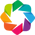

In [153]:
# Separate imports because this cell probably won't stay in this workflow notebook

from typing import Union, List, Optional
import numpy as np
import xarray as xr
import holoviews as hv
import panel as pn
import param
import functools as fct
import itertools as itt
from collections import OrderedDict
from datashader import count_cat
from holoviews.streams import Stream, BoxEdit, RangeXY
from holoviews.operation.datashader import datashade
import holoviews as hv; hv.extension('bokeh')
import panel.widgets as pnwgt
from bokeh.palettes import Category10_10


class VArrayViewer:
    """
    Interactive visualization for movie data arrays.
    
    Parameters
    ----------
    varr : Union[xr.DataArray, List[xr.DataArray], xr.Dataset]
        Input array, list of arrays, or dataset to be visualized. Each array
        should contain dimensions "height", "width" and "frame". If a
        dataset, then the dimensions specified in `meta_dims` will be used
        as metadata dimensions that can uniquely identify each array. If a
        list, then a dimension "data_var" will be constructed and used as
        metadata dimension, and the `.name` attribute of each array will be
        used to identify each array.
    framerate : int, optional
        The framerate of playback when using the toolbar. By default `30`.
    summary : list, optional
        List of summary statistics to plot. The statistics should be one of
        `{"mean", "max", "min", "diff"}`. By default `["mean", "max"]`.
    meta_dims : List[str], optional
        List of dimension names that can uniquely identify each input array
        in `varr`. Only used if `varr` is a `xr.Dataset`. By default `None`.
    datashading : bool, optional
        Whether to use datashading on the summary statistics. By default
        `True`.
    layout : bool, optional
        Whether to visualize all arrays together as layout. If `False` then
        only one array will be visualized and user can switch array using
        drop-down lists below the *Play Toolbar*. By default `False`.

    Raises
    ------
    NotImplementedError
        if `varr` is not a `xr.DataArray`, a `xr.Dataset` or a list of `xr.DataArray`
    
    More:
    ------
    The visualization contains following panels from top to bottom:

    Play Toolbar
        A toolbar that controls playback of the video. Additionally, when the
        button "Update Mask" is clicked, the coordinates of the box drawn in
        *Current Frame* panel will be used to update the `mask` attribute of the
        `VArrayViewer` instance, which can be later used to subset the data. If
        multiple arrays are visualized and `layout` is `False`, then drop-down
        lists corresponding to each metadata dimensions will show up so the user
        can select which array to visualize.
    Current Frame
        Images of the current frame. If multiple movie array are passed in,
        multiple frames will be labeled and shown. To the side of each frame
        there is a histogram of intensity values. The "Box Select" tool can be
        used on the histogram to limit the range of intensity used for
        color-mapping. Additionally, the "Box Edit Tool" is available for use on
        the frame image, where you can hold "Shift" and draw a box, whose
        coordinates can be used to update the `mask` attribute of the
        `VarrayViewer` instance (remember to click "Update Mask" after drawing).
    Summary
        Summary statistics of each frame across time. Only shown if `summary` is
        not empty. The red vertical line indicate current frame.

    Attributes
    ----------
    mask : dict
        Instance attribute that can be retrieved and used to subset data later.
        Keys are `tuple` with values corresponding to each `meta_dims` and
        uniquely identify each input array. If `meta_dims` is empty then keys
        will be empty `tuple` as well. Values are `dict` mapping dimension names
        (of the arrays) to subsetting slices. The slices are in the plotting
        coorandinates and can be directly passed to `xr.DataArray.sel` method to
        subset data.
    """

    def __init__(
        self,
        varr: Union[xr.DataArray, List[xr.DataArray], xr.Dataset],
        framerate=30,
        summary=["mean", "max"],
        meta_dims: List[str] = None,
        datashading=True,
        layout=False,
    ):
        # Handling different types of `varr` input
        if isinstance(varr, list):
            # If `varr` is a list, assign a new coordinate `data_var` using 
            # the name of each array and concatenate them along the `data_var` dimension
            for iv, v in enumerate(varr):
                varr[iv] = v.assign_coords(data_var=v.name)
            self.ds = xr.concat(varr, dim="data_var")
            meta_dims = ["data_var"]
        elif isinstance(varr, xr.DataArray):
            # If `varr` is a DataArray, convert it into a Dataset
            self.ds = varr.to_dataset()
        elif isinstance(varr, xr.Dataset):
            # If `varr` is a Dataset, keep it as it is
            self.ds = varr
        else:
            # If `varr` is not a list, DataArray, or Dataset, raise an error
            raise NotImplementedError(
                "video array of type {} not supported".format(type(varr))
            )

        # Initialize metadata based on the specified metadata dimensions
        try:
            self.meta_dicts = OrderedDict(
                [(d, list(self.ds.coords[d].values)) for d in meta_dims]
            )
            self.cur_metas = OrderedDict(
                [(d, v[0]) for d, v in self.meta_dicts.items()]
            )
        except TypeError:
            self.meta_dicts = dict()
            self.cur_metas = dict()

        # Initialize some attributes
        self._datashade = datashading
        self._layout = layout
        self.framerate = framerate
        self._f = self.ds.coords["frame"].values
        self._h = self.ds.sizes["height"]
        self._w = self.ds.sizes["width"]
        self.mask = dict()

        # Define streams for interaction
        CStream = Stream.define(
            "CStream",
            f=param.Integer(
                default=int(self._f.min()), bounds=(self._f.min(), self._f.max())
            ),
        )
        self.strm_f = CStream()
        self.str_box = BoxEdit()
        self.widgets = self._widgets()

        # Compute and store summary statistics
        if type(summary) is list:
            summ_all = {
                "mean": self.ds.mean(["height", "width"]),
                "max": self.ds.max(["height", "width"]),
                "min": self.ds.min(["height", "width"]),
                "diff": self.ds.diff("frame").mean(["height", "width"]),
            }
            try:
                summ = {k: summ_all[k] for k in summary}
            except KeyError:
                print("{} Not understood for specifying summary".format(summary))
            if summ:
                # print("computing summary")
                sum_list = []
                for k, v in summ.items():
                    sum_list.append(v.compute().assign_coords(sum_var=k))
                summary = xr.concat(sum_list, dim="sum_var")
        self.summary = summary

        # Initialize subsets of data and summary statistics based on layout option
        if layout:
            self.ds_sub = self.ds
            self.sum_sub = self.summary
        else:
            self.ds_sub = self.ds.sel(**self.cur_metas)
            try:
                self.sum_sub = self.summary.sel(**self.cur_metas)
            except AttributeError:
                self.sum_sub = self.summary

        # Generate the panel plot
        self.pnplot = pn.panel(self.get_hvobj())

    def get_hvobj(self):
        """
        Generates a holoviews Layout object of the image stack
        """
        def get_im_ovly(meta):  # Function to generate overlay of image and box
            def img(f, ds):  # Function to generate HoloViews image object for a given frame
                return hv.Image(ds.sel(frame=f).compute(), kdims=["width", "height"])

            # Select a sub-dataset based on metadata; if not possible, use the original dataset
            try:
                curds = self.ds_sub.sel(**meta).rename("_".join(meta.values()))
            except ValueError:
                curds = self.ds_sub

            fim = fct.partial(img, ds=curds)  # Partial function for image generation with current dataset

            # Create a dynamic map for images with the given partial function and frame stream
            im = hv.DynamicMap(fim, streams=[self.strm_f]).opts(
                frame_width=500, aspect=self._w / self._h, cmap="Viridis"
            )

            # Define a range of x and y coordinates for the image
            self.xyrange = RangeXY(source=im).rename(x_range="w", y_range="h")

            # Create a box if layout is not yet defined
            if not self._layout:
                hv_box = hv.Polygons([]).opts(
                    fill_alpha= 0.3, line_color= "white"
                )
                self.str_box = BoxEdit(source=hv_box)
                im_ovly = im * hv_box  # Create an overlay of the image and the box
            else:
                im_ovly = im  # If layout already defined, use the image as is

            def hist(f, w, h, ds):  # Function to generate histogram for given frame, width, height and dataset
                if w and h:
                    cur_im = hv.Image(
                        ds.sel(frame=f).compute(), kdims=["width", "height"]
                    ).select(height=h, width=w)
                else:
                    cur_im = hv.Image(
                        ds.sel(frame=f).compute(), kdims=["width", "height"]
                    )
                return hv.operation.histogram(cur_im, num_bins=50).opts(
                    xlabel="fluorescence", ylabel="freq"
                )

            fhist = fct.partial(hist, ds=curds)  # Partial function for histogram generation with current dataset

            # Create a dynamic map for histograms with the given partial function and frame & xy range streams
            his = hv.DynamicMap(fhist, streams=[self.strm_f, self.xyrange]).opts(
                frame_height=int(500 * self._h / self._w), width=150, cmap="Viridis"
            )

            # add the histogram as an adjoint subfig
            im_ovly = im_ovly << his

            return im_ovly  # Return the overlay object

        # If layout is defined and metadata is available
        if self._layout and self.meta_dicts:
            im_dict = OrderedDict()  # Initialize an ordered dictionary to store the images
            for meta in itt.product(*list(self.meta_dicts.values())):  # For each combination of metadata values
                mdict = {k: v for k, v in zip(list(self.meta_dicts.keys()), meta)}  # Map each metadata key to its value
                im_dict[meta] = get_im_ovly(mdict)  # Add the generated overlay to the dictionary

            # Generate a HoloViews NdLayout object from the image dictionary
            ims = hv.NdLayout(im_dict, kdims=list(self.meta_dicts.keys()))
        else:
            # If no layout or metadata, generate an overlay for the current metadata
            ims = get_im_ovly(self.cur_metas)

        if self.summary is not None:  # If summary data is available
            # Generate a HoloViews Curve object from the summary data
            hvsum = (
                hv.Dataset(self.sum_sub)
                .to(hv.Curve, kdims=["frame"])
                .overlay("sum_var")
            )

            # Apply data shading if required
            if self._datashade:
                hvsum = datashade_ndcurve(hvsum, kdim="sum_var")

            try:
                hvsum = hvsum.layout(list(self.meta_dicts.keys()))  # Arrange the summary layout based on metadata
            except:
                pass

            # Generate a vertical line to indicate the current frame
            vl = hv.DynamicMap(lambda f: hv.VLine(f), streams=[self.strm_f]).opts(
                color="red")

            # Combine the summary curves and the vertical line, and apply dimensions and a colormap
            summ = (hvsum * vl).map(
                lambda p: p.opts(frame_width=500, aspect=3), [hv.RGB, hv.Curve]
            )

            # Combine the images and the summary into a single layout, arranged in columns
            hvobj = (ims + summ).cols(1)
        else:
            hvobj = ims  # If no summary data, the layout is just the images

        return hvobj  # Return the layout object


    def show(self) -> pn.layout.Column:
        # Return widgets and plots in a layout
        return pn.layout.Column(self.widgets, self.pnplot)

    def _widgets(self):
        w_play = pnwgt.Player(
            length=len(self._f), interval=1000//self.framerate, value=0, width=650, height=90
        )

        def play(f):
            if not f.old == f.new:
                self.strm_f.event(f=int(self._f[f.new]))

        w_play.param.watch(play, "value")
        w_box = pnwgt.Button(
            name="Update Mask", button_type="primary", width=100, height=30
        )
        w_box.param.watch(self._update_box, "clicks")
        if not self._layout:
            wgt_meta = {
                d: pnwgt.Select(name=d, options=v, height=45, width=120)
                for d, v in self.meta_dicts.items()
            }

            def make_update_func(meta_name):
                def _update(x):
                    self.cur_metas[meta_name] = x.new
                    self._update_subs()

                return _update

            for d, wgt in wgt_meta.items():
                cur_update = make_update_func(d)
                wgt.param.watch(cur_update, "value")
            wgts = pn.layout.WidgetBox(w_box, w_play, *list(wgt_meta.values()))
        else:
            wgts = pn.layout.WidgetBox(w_box, w_play)
        return wgts

    def _update_subs(self):
        self.ds_sub = self.ds.sel(**self.cur_metas)
        if self.sum_sub is not None:
            self.sum_sub = self.summary.sel(**self.cur_metas)
        self.pnplot.objects[0].object = self.get_hvobj()

    def _update_box(self, click):
        box = self.str_box.data
        self.mask.update(
            {
                tuple(self.cur_metas.values()): {
                    "height": slice(box["y0"][0], box["y1"][0]),
                    "width": slice(box["x0"][0], box["x1"][0]),
                }
            }
        )

def datashade_ndcurve(
    ovly: hv.NdOverlay, kdim: Optional[Union[str, List[str]]] = None, spread=False
) -> hv.Overlay:
    """
    Apply datashading to an overlay of curves with legends.

    Parameters
    ----------
    ovly : hv.NdOverlay
        The input overlay of curves.
    kdim : Union[str, List[str]], optional
        Key dimensions of the overlay. If `None` then the first key dimension of
        `ovly` will be used. By default `None`.
    spread : bool, optional
        Whether to apply :func:`holoviews.operation.datashader.dynspread` to the
        result. By default `False`.

    Returns
    -------
    hvres : hv.Overlay
        Resulting overlay of datashaded curves and points (for legends).
    """
    if not kdim:
        kdim = ovly.kdims[0].name
    var = np.unique(ovly.dimension_values(kdim)).tolist()
    color_key = [(v, Category10_10[iv]) for iv, v in enumerate(var)]
    color_pts = hv.NdOverlay(
        {
            k: hv.Points([0, 0], label=str(k)).opts(color=v)
            for k, v in color_key
        }
    )
    ds_ovly = datashade(
        ovly,
        aggregator=count_cat(kdim),
        color_key=dict(color_key),
        min_alpha=200,
        normalization="linear",
    )
    if spread:
        ds_ovly = dynspread(ds_ovly)
    return ds_ovly * color_pts

In [154]:
vaviewer = VArrayViewer(data)
vaviewer.show()

Column
    [0] WidgetBox
        [0] Button(button_type='primary', height=30, name='Update Mask', sizing_mode='fixed', width=100)
        [1] Player(end=299, height=90, interval=33, sizing_mode='fixed', width=650)
    [1] HoloViews(Layout)

## Load and plot real data